# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from dl4cv.classifiers.fc_net import *
from dl4cv.data_utils import get_CIFAR10_data
from dl4cv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl4cv.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (48000, 3, 32, 32)
y_train:  (48000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine layer: foward
Open the file `dl4cv/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984946819e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.55125817465e-09
dw error:  1.80212365625e-10
db error:  2.98320541083e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
#x = np.random.randn(3, 3)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
print("shape of dx_num = ", dx_num.shape)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

shape of dx_num =  (10, 10)
Testing relu_backward function:
dx error:  3.27560098365e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `dl4cv/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from dl4cv.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  4.86398746198e-10
dw error:  4.75547369766e-10
db error:  5.65321450482e-12


# Loss layers: Softmax
You implemented this loss function in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `dl4cv/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.30277878303
dx error:  6.95976015994e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `dl4cv/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.35e-08
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `dl4cv/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet(hidden_dim=150, reg=1e-3, weight_scale=1e-3)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
#data = {
#    'X_train': # training data
#    'y_train': # training labels
#    'X_val': # validation data
#    'X_train': # validation labels
#}
#model = MyAwesomeModel(hidden_size=100, reg=10)
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=20, batch_size=100,
                print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 9600) loss: 2.306340
(Epoch 0 / 20) train acc: 0.133000; val_acc: 0.106000
(Iteration 101 / 9600) loss: 1.652857
(Iteration 201 / 9600) loss: 1.648114
(Iteration 301 / 9600) loss: 1.600021
(Iteration 401 / 9600) loss: 1.623219
(Epoch 1 / 20) train acc: 0.434000; val_acc: 0.421000
(Iteration 501 / 9600) loss: 1.435270
(Iteration 601 / 9600) loss: 1.526372
(Iteration 701 / 9600) loss: 1.527576
(Iteration 801 / 9600) loss: 1.338534
(Iteration 901 / 9600) loss: 1.505925
(Epoch 2 / 20) train acc: 0.494000; val_acc: 0.458000
(Iteration 1001 / 9600) loss: 1.427786
(Iteration 1101 / 9600) loss: 1.266801
(Iteration 1201 / 9600) loss: 1.299251
(Iteration 1301 / 9600) loss: 1.292057
(Iteration 1401 / 9600) loss: 1.523774
(Epoch 3 / 20) train acc: 0.514000; val_acc: 0.503000
(Iteration 1501 / 9600) loss: 1.318000
(Iteration 1601 / 9600) loss: 1.181025
(Iteration 1701 / 9600) loss: 1.284029
(Iteration 1801 / 9600) loss: 1.351212
(Iteration 1901 / 9600) loss: 1.024331
(Epoch 4 / 20) t

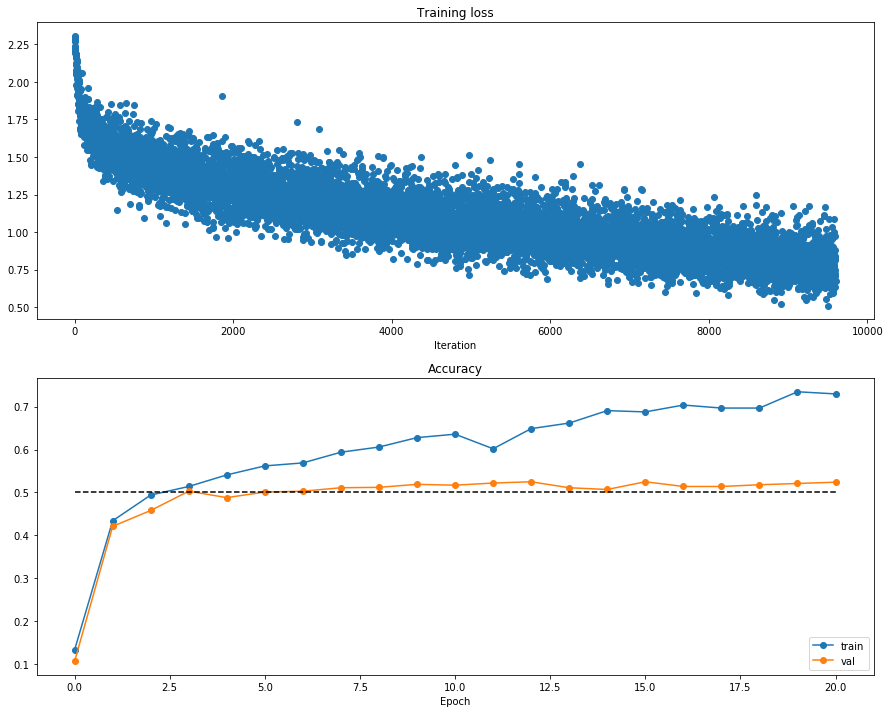

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `dl4cv/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  3.42986964022
W1 relative error: 5.35e-08
W2 relative error: 3.32e-08
b1 relative error: 8.37e-10
b2 relative error: 3.49e-10
Running check with reg =  3.14
Initial loss:  7.05124160733
W1 relative error: 3.85e-09
W2 relative error: 2.48e-08
b1 relative error: 3.63e-07
b2 relative error: 7.61e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% **training** accuracy within 20 epochs.

(Iteration 1 / 40) loss: 162.799951
(Epoch 0 / 20) train acc: 0.320000; val_acc: 0.117000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.131000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 3 / 20) train acc: 0.780000; val_acc: 0.128000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.125000
(Iteration 11 / 40) loss: 1.547750
(Epoch 6 / 20) train acc: 0.980000; val_acc: 0.144000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.143000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.141000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.142000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.142000
(Iteration 21 / 40) loss: 0.000017
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.142000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.142000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.142000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.142000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.142000
(Iteration 31 / 40) loss

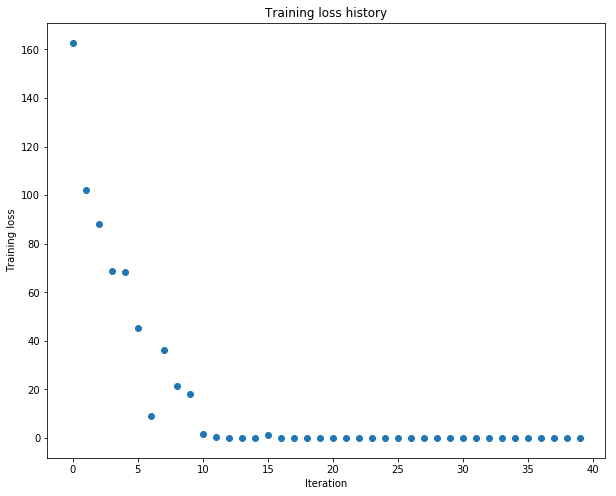

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 5e-2
learning_rate = 1e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 18.463421
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.123000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.136000
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.116000
(Epoch 3 / 20) train acc: 0.720000; val_acc: 0.130000
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.149000
(Epoch 5 / 20) train acc: 0.980000; val_acc: 0.159000
(Iteration 11 / 40) loss: 0.161817
(Epoch 6 / 20) train acc: 0.980000; val_acc: 0.162000
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.155000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.164000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.162000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.161000
(Iteration 21 / 40) loss: 0.018550
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.159000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.160000
(Iteration 31 / 40) loss:

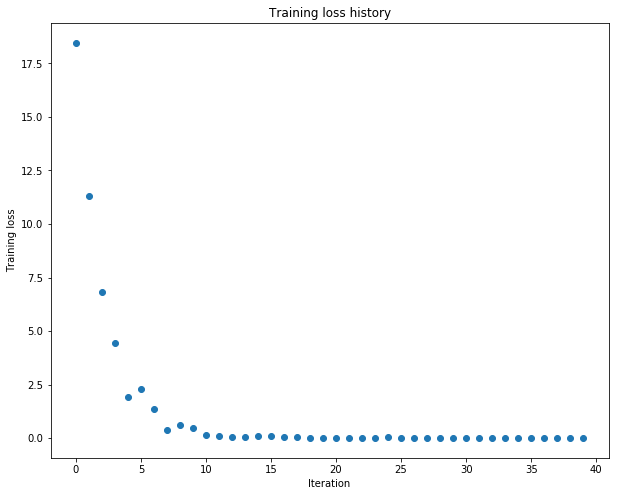

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

# implement your training code here
weight_scale = 5e-2
learning_rate = 5e-3
model = FullyConnectedNet([100, 100, 100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?</p>
    <p>**Your answer:**</p>
</div>


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `dl4cv/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [15]:
from dl4cv.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 800) loss: 4.596988
(Epoch 0 / 20) train acc: 0.031000; val_acc: 0.033000
(Iteration 11 / 800) loss: 2.975174
(Iteration 21 / 800) loss: 2.586450
(Iteration 31 / 800) loss: 2.726732
(Epoch 1 / 20) train acc: 0.167000; val_acc: 0.160000
(Iteration 41 / 800) loss: 2.422729
(Iteration 51 / 800) loss: 2.204476
(Iteration 61 / 800) loss: 2.116545
(Iteration 71 / 800) loss: 2.404646
(Epoch 2 / 20) train acc: 0.282000; val_acc: 0.256000
(Iteration 81 / 800) loss: 1.935098
(Iteration 91 / 800) loss: 2.078727
(Iteration 101 / 800) loss: 1.926655
(Iteration 111 / 800) loss: 1.848814
(Epoch 3 / 20) train acc: 0.347000; val_acc: 0.298000
(Iteration 121 / 800) loss: 1.961799
(Iteration 131 / 800) loss: 1.781718
(Iteration 141 / 800) loss: 2.061377
(Iteration 151 / 800) loss: 1.742760
(Epoch 4 / 20) train acc: 0.329000; val_acc: 0.288000
(Iteration 161 / 800) loss: 1.819143
(Iteration 171 / 800) loss: 1.766791
(Iteration 181 / 800) loss: 1.675758
(Iteration 191 / 800

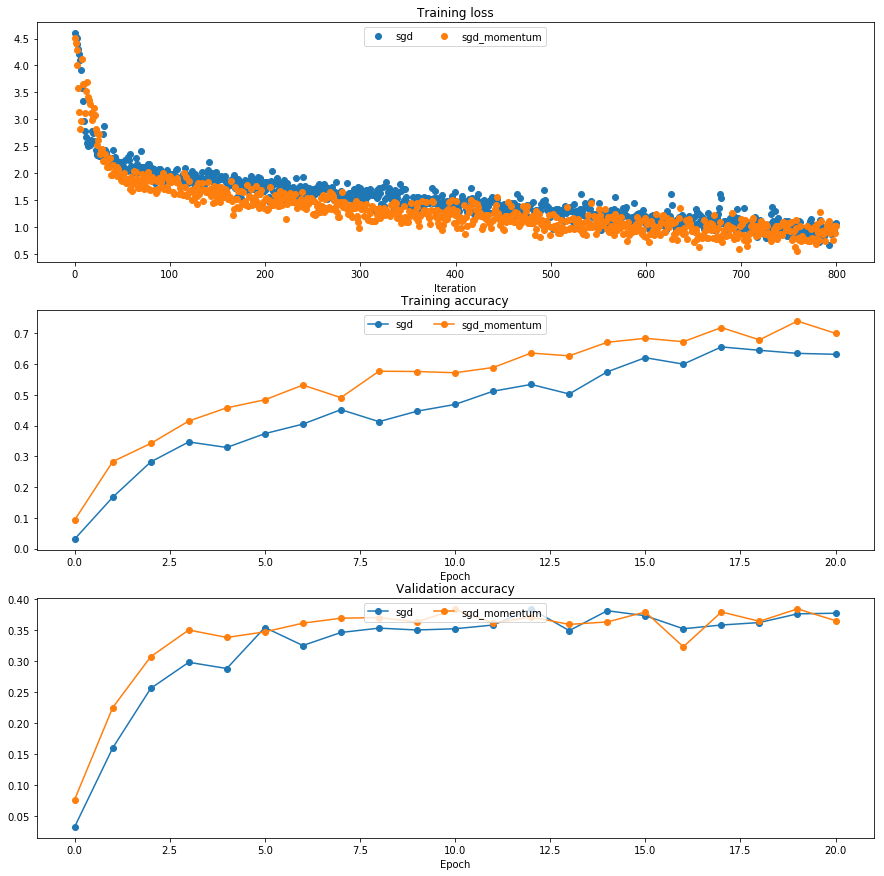

In [16]:
num_train = 4000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=3e-2)

    solver = Solver(model, small_data,
                    num_epochs=20, batch_size=100,
                    update_rule=update_rule,
                    optim_config={'learning_rate': 1e-2},
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Adam [1] is an update rule that sets per-parameter learning rates by using a running average of the second moments of gradients.

In the file `dl4cv/optim.py`, we have implemented the update rule `adam` for you. Check this implementation and make sure you understand what the optimizer is doing. Then train the fully connected net below to see how Adam affects the learning process.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

running with  adam
(Iteration 1 / 800) loss: 7.249222
(Epoch 0 / 20) train acc: 0.112000; val_acc: 0.140000
(Iteration 11 / 800) loss: 2.747288
(Iteration 21 / 800) loss: 2.333278
(Iteration 31 / 800) loss: 2.177488
(Epoch 1 / 20) train acc: 0.281000; val_acc: 0.257000
(Iteration 41 / 800) loss: 1.962930
(Iteration 51 / 800) loss: 1.974054
(Iteration 61 / 800) loss: 2.041465
(Iteration 71 / 800) loss: 1.995787
(Epoch 2 / 20) train acc: 0.333000; val_acc: 0.317000
(Iteration 81 / 800) loss: 1.855648
(Iteration 91 / 800) loss: 1.805750
(Iteration 101 / 800) loss: 1.753797
(Iteration 111 / 800) loss: 1.753367
(Epoch 3 / 20) train acc: 0.392000; val_acc: 0.340000
(Iteration 121 / 800) loss: 1.869546
(Iteration 131 / 800) loss: 1.720142
(Iteration 141 / 800) loss: 1.779665
(Iteration 151 / 800) loss: 1.731180
(Epoch 4 / 20) train acc: 0.376000; val_acc: 0.335000
(Iteration 161 / 800) loss: 1.602630
(Iteration 171 / 800) loss: 1.495480
(Iteration 181 / 800) loss: 1.489421
(Iteration 191 / 80

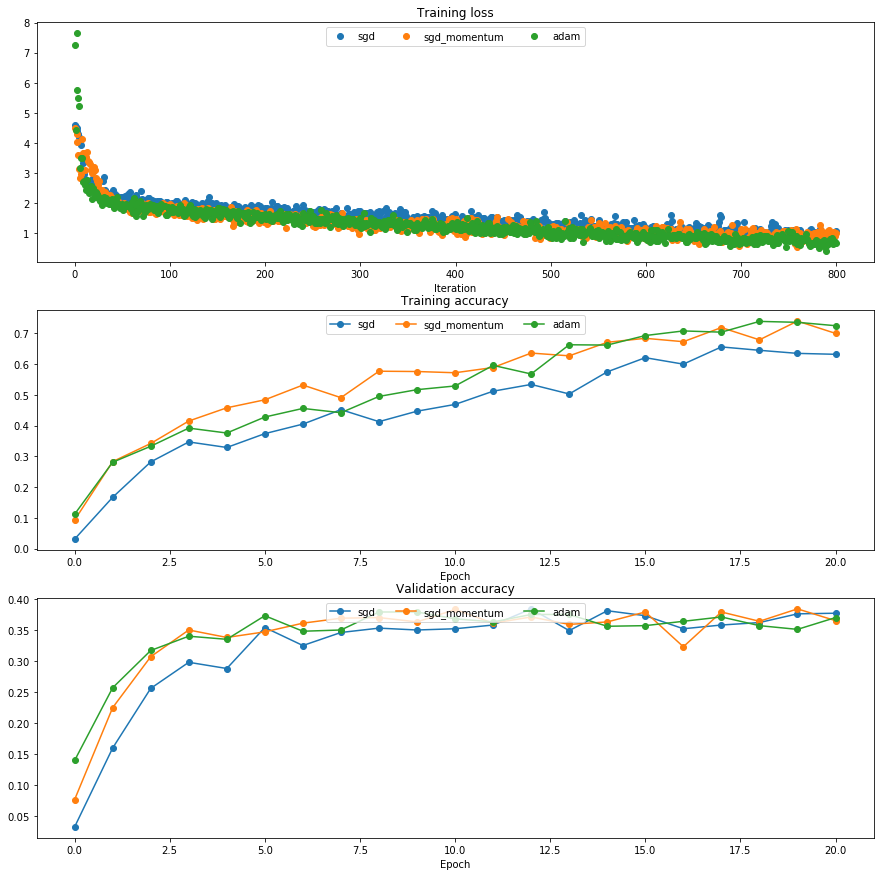

In [17]:
learning_rates = {'adam': 1e-3}
update_rule = 'adam'
print('running with ', update_rule)
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(model, small_data,
              num_epochs=20, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solvers[update_rule] = solver
solver.train()
print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 48% accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `2_BatchNormalization.ipynb` notebook before completing this part, since this technique can help you train powerful models.

running with  sgd_momentum
(Iteration 1 / 14400) loss: 4.601249
(Epoch 0 / 30) train acc: 0.011000; val_acc: 0.017000
(Iteration 11 / 14400) loss: 3.911212
(Iteration 21 / 14400) loss: 2.854760
(Iteration 31 / 14400) loss: 2.184573
(Iteration 41 / 14400) loss: 1.971127
(Iteration 51 / 14400) loss: 1.886119
(Iteration 61 / 14400) loss: 1.957825
(Iteration 71 / 14400) loss: 1.939694
(Iteration 81 / 14400) loss: 1.748609
(Iteration 91 / 14400) loss: 1.642144
(Iteration 101 / 14400) loss: 1.759878
(Iteration 111 / 14400) loss: 1.782434
(Iteration 121 / 14400) loss: 1.679271
(Iteration 131 / 14400) loss: 1.768168
(Iteration 141 / 14400) loss: 1.715842
(Iteration 151 / 14400) loss: 1.568790
(Iteration 161 / 14400) loss: 1.724968
(Iteration 171 / 14400) loss: 1.703056
(Iteration 181 / 14400) loss: 1.643384
(Iteration 191 / 14400) loss: 1.706908
(Iteration 201 / 14400) loss: 1.884520
(Iteration 211 / 14400) loss: 1.603302
(Iteration 221 / 14400) loss: 1.528732
(Iteration 231 / 14400) loss: 1.8

(Iteration 2011 / 14400) loss: 1.035440
(Iteration 2021 / 14400) loss: 1.102889
(Iteration 2031 / 14400) loss: 1.207402
(Iteration 2041 / 14400) loss: 1.122923
(Iteration 2051 / 14400) loss: 1.357543
(Iteration 2061 / 14400) loss: 1.272138
(Iteration 2071 / 14400) loss: 1.261363
(Iteration 2081 / 14400) loss: 1.327285
(Iteration 2091 / 14400) loss: 1.155267
(Iteration 2101 / 14400) loss: 1.246814
(Iteration 2111 / 14400) loss: 0.975012
(Iteration 2121 / 14400) loss: 1.208395
(Iteration 2131 / 14400) loss: 1.143561
(Iteration 2141 / 14400) loss: 1.327662
(Iteration 2151 / 14400) loss: 1.344655
(Iteration 2161 / 14400) loss: 1.172014
(Iteration 2171 / 14400) loss: 1.109910
(Iteration 2181 / 14400) loss: 1.161950
(Iteration 2191 / 14400) loss: 1.137570
(Iteration 2201 / 14400) loss: 1.281600
(Iteration 2211 / 14400) loss: 1.000008
(Iteration 2221 / 14400) loss: 1.315243
(Iteration 2231 / 14400) loss: 1.190364
(Iteration 2241 / 14400) loss: 1.151651
(Iteration 2251 / 14400) loss: 1.049719


(Iteration 4021 / 14400) loss: 1.127091
(Iteration 4031 / 14400) loss: 1.057296
(Iteration 4041 / 14400) loss: 1.419344
(Iteration 4051 / 14400) loss: 1.066704
(Iteration 4061 / 14400) loss: 1.005812
(Iteration 4071 / 14400) loss: 0.908452
(Iteration 4081 / 14400) loss: 1.143200
(Iteration 4091 / 14400) loss: 1.057520
(Iteration 4101 / 14400) loss: 1.011589
(Iteration 4111 / 14400) loss: 0.928279
(Iteration 4121 / 14400) loss: 0.907418
(Iteration 4131 / 14400) loss: 0.956003
(Iteration 4141 / 14400) loss: 1.090145
(Iteration 4151 / 14400) loss: 1.163207
(Iteration 4161 / 14400) loss: 1.253435
(Iteration 4171 / 14400) loss: 1.048643
(Iteration 4181 / 14400) loss: 1.257467
(Iteration 4191 / 14400) loss: 1.058126
(Iteration 4201 / 14400) loss: 1.174819
(Iteration 4211 / 14400) loss: 1.109758
(Iteration 4221 / 14400) loss: 1.058856
(Iteration 4231 / 14400) loss: 1.004856
(Iteration 4241 / 14400) loss: 0.849457
(Iteration 4251 / 14400) loss: 1.060465
(Iteration 4261 / 14400) loss: 1.227738


(Iteration 6031 / 14400) loss: 0.917275
(Iteration 6041 / 14400) loss: 0.877735
(Iteration 6051 / 14400) loss: 0.916294
(Iteration 6061 / 14400) loss: 1.142037
(Iteration 6071 / 14400) loss: 0.896299
(Iteration 6081 / 14400) loss: 1.008932
(Iteration 6091 / 14400) loss: 1.169972
(Iteration 6101 / 14400) loss: 0.966563
(Iteration 6111 / 14400) loss: 0.879849
(Iteration 6121 / 14400) loss: 0.775510
(Iteration 6131 / 14400) loss: 0.923012
(Iteration 6141 / 14400) loss: 0.850698
(Iteration 6151 / 14400) loss: 0.743128
(Iteration 6161 / 14400) loss: 0.964896
(Iteration 6171 / 14400) loss: 0.813949
(Iteration 6181 / 14400) loss: 0.996739
(Iteration 6191 / 14400) loss: 0.899424
(Iteration 6201 / 14400) loss: 0.950784
(Iteration 6211 / 14400) loss: 1.181543
(Iteration 6221 / 14400) loss: 0.995378
(Iteration 6231 / 14400) loss: 1.004004
(Epoch 13 / 30) train acc: 0.677000; val_acc: 0.539000
(Iteration 6241 / 14400) loss: 0.906693
(Iteration 6251 / 14400) loss: 0.863723
(Iteration 6261 / 14400) 

(Iteration 8041 / 14400) loss: 1.079191
(Iteration 8051 / 14400) loss: 0.944008
(Iteration 8061 / 14400) loss: 0.836071
(Iteration 8071 / 14400) loss: 1.009870
(Iteration 8081 / 14400) loss: 0.879872
(Iteration 8091 / 14400) loss: 0.915403
(Iteration 8101 / 14400) loss: 0.829446
(Iteration 8111 / 14400) loss: 0.856817
(Iteration 8121 / 14400) loss: 0.705335
(Iteration 8131 / 14400) loss: 0.847564
(Iteration 8141 / 14400) loss: 0.812474
(Iteration 8151 / 14400) loss: 0.807712
(Epoch 17 / 30) train acc: 0.748000; val_acc: 0.534000
(Iteration 8161 / 14400) loss: 0.707392
(Iteration 8171 / 14400) loss: 0.634338
(Iteration 8181 / 14400) loss: 0.892139
(Iteration 8191 / 14400) loss: 1.122993
(Iteration 8201 / 14400) loss: 0.871617
(Iteration 8211 / 14400) loss: 0.793992
(Iteration 8221 / 14400) loss: 0.884340
(Iteration 8231 / 14400) loss: 0.770858
(Iteration 8241 / 14400) loss: 0.754684
(Iteration 8251 / 14400) loss: 0.824570
(Iteration 8261 / 14400) loss: 0.807319
(Iteration 8271 / 14400) 

(Iteration 10051 / 14400) loss: 0.672964
(Iteration 10061 / 14400) loss: 0.887201
(Iteration 10071 / 14400) loss: 0.653691
(Epoch 21 / 30) train acc: 0.736000; val_acc: 0.539000
(Iteration 10081 / 14400) loss: 0.845758
(Iteration 10091 / 14400) loss: 0.775080
(Iteration 10101 / 14400) loss: 0.780440
(Iteration 10111 / 14400) loss: 0.775527
(Iteration 10121 / 14400) loss: 0.841662
(Iteration 10131 / 14400) loss: 0.718256
(Iteration 10141 / 14400) loss: 0.728202
(Iteration 10151 / 14400) loss: 1.012923
(Iteration 10161 / 14400) loss: 0.662913
(Iteration 10171 / 14400) loss: 0.656737
(Iteration 10181 / 14400) loss: 0.841443
(Iteration 10191 / 14400) loss: 0.786176
(Iteration 10201 / 14400) loss: 0.672214
(Iteration 10211 / 14400) loss: 0.661130
(Iteration 10221 / 14400) loss: 0.590548
(Iteration 10231 / 14400) loss: 0.828460
(Iteration 10241 / 14400) loss: 0.894347
(Iteration 10251 / 14400) loss: 0.776612
(Iteration 10261 / 14400) loss: 0.614729
(Iteration 10271 / 14400) loss: 0.676051
(I

(Epoch 25 / 30) train acc: 0.748000; val_acc: 0.544000
(Iteration 12001 / 14400) loss: 0.707369
(Iteration 12011 / 14400) loss: 0.547801
(Iteration 12021 / 14400) loss: 0.784852
(Iteration 12031 / 14400) loss: 0.713664
(Iteration 12041 / 14400) loss: 0.567227
(Iteration 12051 / 14400) loss: 0.686988
(Iteration 12061 / 14400) loss: 0.847495
(Iteration 12071 / 14400) loss: 0.768034
(Iteration 12081 / 14400) loss: 0.570272
(Iteration 12091 / 14400) loss: 0.695127
(Iteration 12101 / 14400) loss: 0.795993
(Iteration 12111 / 14400) loss: 0.779523
(Iteration 12121 / 14400) loss: 0.689907
(Iteration 12131 / 14400) loss: 0.575879
(Iteration 12141 / 14400) loss: 0.624086
(Iteration 12151 / 14400) loss: 0.795310
(Iteration 12161 / 14400) loss: 0.869872
(Iteration 12171 / 14400) loss: 0.846038
(Iteration 12181 / 14400) loss: 0.743033
(Iteration 12191 / 14400) loss: 0.784925
(Iteration 12201 / 14400) loss: 0.760361
(Iteration 12211 / 14400) loss: 0.677809
(Iteration 12221 / 14400) loss: 0.754329
(I

(Iteration 13951 / 14400) loss: 0.655074
(Iteration 13961 / 14400) loss: 0.668636
(Iteration 13971 / 14400) loss: 0.658785
(Iteration 13981 / 14400) loss: 0.821167
(Iteration 13991 / 14400) loss: 0.771519
(Iteration 14001 / 14400) loss: 0.648266
(Iteration 14011 / 14400) loss: 0.536417
(Iteration 14021 / 14400) loss: 0.646276
(Iteration 14031 / 14400) loss: 0.520394
(Iteration 14041 / 14400) loss: 0.795288
(Iteration 14051 / 14400) loss: 0.685285
(Iteration 14061 / 14400) loss: 0.647838
(Iteration 14071 / 14400) loss: 0.699080
(Iteration 14081 / 14400) loss: 0.710265
(Iteration 14091 / 14400) loss: 0.491491
(Iteration 14101 / 14400) loss: 0.758383
(Iteration 14111 / 14400) loss: 0.882412
(Iteration 14121 / 14400) loss: 0.694691
(Iteration 14131 / 14400) loss: 0.695220
(Iteration 14141 / 14400) loss: 0.605234
(Iteration 14151 / 14400) loss: 0.552048
(Iteration 14161 / 14400) loss: 0.746165
(Iteration 14171 / 14400) loss: 0.568036
(Iteration 14181 / 14400) loss: 0.619463
(Iteration 14191

(Iteration 1551 / 14400) loss: 1.162265
(Iteration 1561 / 14400) loss: 1.154960
(Iteration 1571 / 14400) loss: 1.236107
(Iteration 1581 / 14400) loss: 1.379798
(Iteration 1591 / 14400) loss: 1.466190
(Iteration 1601 / 14400) loss: 1.338349
(Iteration 1611 / 14400) loss: 1.151450
(Iteration 1621 / 14400) loss: 1.196237
(Iteration 1631 / 14400) loss: 1.380380
(Iteration 1641 / 14400) loss: 1.305342
(Iteration 1651 / 14400) loss: 1.144973
(Iteration 1661 / 14400) loss: 1.078481
(Iteration 1671 / 14400) loss: 1.203602
(Iteration 1681 / 14400) loss: 1.477238
(Iteration 1691 / 14400) loss: 1.266305
(Iteration 1701 / 14400) loss: 1.368386
(Iteration 1711 / 14400) loss: 1.284314
(Iteration 1721 / 14400) loss: 1.238673
(Iteration 1731 / 14400) loss: 1.206653
(Iteration 1741 / 14400) loss: 1.452333
(Iteration 1751 / 14400) loss: 1.181060
(Iteration 1761 / 14400) loss: 1.335127
(Iteration 1771 / 14400) loss: 1.140474
(Iteration 1781 / 14400) loss: 1.221127
(Iteration 1791 / 14400) loss: 1.169884


(Iteration 3551 / 14400) loss: 0.900165
(Iteration 3561 / 14400) loss: 1.080329
(Iteration 3571 / 14400) loss: 0.888158
(Iteration 3581 / 14400) loss: 1.013951
(Iteration 3591 / 14400) loss: 1.018101
(Iteration 3601 / 14400) loss: 1.118344
(Iteration 3611 / 14400) loss: 1.189431
(Iteration 3621 / 14400) loss: 1.098697
(Iteration 3631 / 14400) loss: 1.167898
(Iteration 3641 / 14400) loss: 1.297745
(Iteration 3651 / 14400) loss: 1.151528
(Iteration 3661 / 14400) loss: 1.077756
(Iteration 3671 / 14400) loss: 1.107707
(Iteration 3681 / 14400) loss: 0.969911
(Iteration 3691 / 14400) loss: 1.069294
(Iteration 3701 / 14400) loss: 1.082831
(Iteration 3711 / 14400) loss: 1.198018
(Iteration 3721 / 14400) loss: 1.148722
(Iteration 3731 / 14400) loss: 0.998166
(Iteration 3741 / 14400) loss: 1.148904
(Iteration 3751 / 14400) loss: 1.059184
(Iteration 3761 / 14400) loss: 0.963589
(Iteration 3771 / 14400) loss: 0.990194
(Iteration 3781 / 14400) loss: 0.903026
(Iteration 3791 / 14400) loss: 0.988483


(Iteration 5551 / 14400) loss: 0.830940
(Iteration 5561 / 14400) loss: 0.992490
(Iteration 5571 / 14400) loss: 1.259556
(Iteration 5581 / 14400) loss: 1.049072
(Iteration 5591 / 14400) loss: 0.878481
(Iteration 5601 / 14400) loss: 1.019113
(Iteration 5611 / 14400) loss: 0.923118
(Iteration 5621 / 14400) loss: 0.753066
(Iteration 5631 / 14400) loss: 0.870663
(Iteration 5641 / 14400) loss: 0.985894
(Iteration 5651 / 14400) loss: 1.109369
(Iteration 5661 / 14400) loss: 0.820091
(Iteration 5671 / 14400) loss: 0.886236
(Iteration 5681 / 14400) loss: 0.836049
(Iteration 5691 / 14400) loss: 0.780725
(Iteration 5701 / 14400) loss: 1.122998
(Iteration 5711 / 14400) loss: 1.114526
(Iteration 5721 / 14400) loss: 1.064537
(Iteration 5731 / 14400) loss: 0.790896
(Iteration 5741 / 14400) loss: 1.000533
(Iteration 5751 / 14400) loss: 0.881488
(Epoch 12 / 30) train acc: 0.667000; val_acc: 0.519000
(Iteration 5761 / 14400) loss: 0.947324
(Iteration 5771 / 14400) loss: 1.059656
(Iteration 5781 / 14400) 

(Iteration 7561 / 14400) loss: 0.975089
(Iteration 7571 / 14400) loss: 0.657906
(Iteration 7581 / 14400) loss: 0.844405
(Iteration 7591 / 14400) loss: 0.816955
(Iteration 7601 / 14400) loss: 0.817085
(Iteration 7611 / 14400) loss: 1.105670
(Iteration 7621 / 14400) loss: 0.756008
(Iteration 7631 / 14400) loss: 0.832939
(Iteration 7641 / 14400) loss: 0.731301
(Iteration 7651 / 14400) loss: 0.867114
(Iteration 7661 / 14400) loss: 0.870191
(Iteration 7671 / 14400) loss: 0.768816
(Epoch 16 / 30) train acc: 0.697000; val_acc: 0.524000
(Iteration 7681 / 14400) loss: 0.776147
(Iteration 7691 / 14400) loss: 1.023344
(Iteration 7701 / 14400) loss: 0.694879
(Iteration 7711 / 14400) loss: 1.154511
(Iteration 7721 / 14400) loss: 0.789575
(Iteration 7731 / 14400) loss: 0.869597
(Iteration 7741 / 14400) loss: 0.863935
(Iteration 7751 / 14400) loss: 0.911901
(Iteration 7761 / 14400) loss: 0.998554
(Iteration 7771 / 14400) loss: 0.943166
(Iteration 7781 / 14400) loss: 1.001494
(Iteration 7791 / 14400) 

(Iteration 9561 / 14400) loss: 0.727445
(Iteration 9571 / 14400) loss: 0.605340
(Iteration 9581 / 14400) loss: 0.751233
(Iteration 9591 / 14400) loss: 0.947640
(Epoch 20 / 30) train acc: 0.721000; val_acc: 0.530000
(Iteration 9601 / 14400) loss: 0.671874
(Iteration 9611 / 14400) loss: 0.895323
(Iteration 9621 / 14400) loss: 0.784883
(Iteration 9631 / 14400) loss: 0.822723
(Iteration 9641 / 14400) loss: 0.651604
(Iteration 9651 / 14400) loss: 0.814436
(Iteration 9661 / 14400) loss: 0.722316
(Iteration 9671 / 14400) loss: 0.857483
(Iteration 9681 / 14400) loss: 0.754474
(Iteration 9691 / 14400) loss: 0.622110
(Iteration 9701 / 14400) loss: 0.880598
(Iteration 9711 / 14400) loss: 0.698180
(Iteration 9721 / 14400) loss: 0.764611
(Iteration 9731 / 14400) loss: 0.853372
(Iteration 9741 / 14400) loss: 0.615793
(Iteration 9751 / 14400) loss: 1.005438
(Iteration 9761 / 14400) loss: 0.689551
(Iteration 9771 / 14400) loss: 0.705748
(Iteration 9781 / 14400) loss: 0.802972
(Iteration 9791 / 14400) 

(Epoch 24 / 30) train acc: 0.765000; val_acc: 0.534000
(Iteration 11521 / 14400) loss: 0.815225
(Iteration 11531 / 14400) loss: 0.767560
(Iteration 11541 / 14400) loss: 0.873159
(Iteration 11551 / 14400) loss: 0.580149
(Iteration 11561 / 14400) loss: 0.585625
(Iteration 11571 / 14400) loss: 0.706879
(Iteration 11581 / 14400) loss: 0.853760
(Iteration 11591 / 14400) loss: 0.952807
(Iteration 11601 / 14400) loss: 0.769994
(Iteration 11611 / 14400) loss: 0.838438
(Iteration 11621 / 14400) loss: 0.660548
(Iteration 11631 / 14400) loss: 0.475518
(Iteration 11641 / 14400) loss: 0.698633
(Iteration 11651 / 14400) loss: 0.882951
(Iteration 11661 / 14400) loss: 0.743515
(Iteration 11671 / 14400) loss: 0.871041
(Iteration 11681 / 14400) loss: 0.622784
(Iteration 11691 / 14400) loss: 0.848029
(Iteration 11701 / 14400) loss: 0.823161
(Iteration 11711 / 14400) loss: 0.652295
(Iteration 11721 / 14400) loss: 0.677658
(Iteration 11731 / 14400) loss: 0.778998
(Iteration 11741 / 14400) loss: 0.624145
(I

(Iteration 13461 / 14400) loss: 0.571184
(Iteration 13471 / 14400) loss: 0.645545
(Iteration 13481 / 14400) loss: 0.756806
(Iteration 13491 / 14400) loss: 0.724583
(Iteration 13501 / 14400) loss: 0.636263
(Iteration 13511 / 14400) loss: 0.633381
(Iteration 13521 / 14400) loss: 0.671067
(Iteration 13531 / 14400) loss: 0.598668
(Iteration 13541 / 14400) loss: 0.500646
(Iteration 13551 / 14400) loss: 0.629999
(Iteration 13561 / 14400) loss: 0.851268
(Iteration 13571 / 14400) loss: 0.813382
(Iteration 13581 / 14400) loss: 0.494566
(Iteration 13591 / 14400) loss: 0.596859
(Iteration 13601 / 14400) loss: 0.729152
(Iteration 13611 / 14400) loss: 0.609073
(Iteration 13621 / 14400) loss: 0.651538
(Iteration 13631 / 14400) loss: 0.615929
(Iteration 13641 / 14400) loss: 0.583182
(Iteration 13651 / 14400) loss: 0.715172
(Iteration 13661 / 14400) loss: 0.713759
(Iteration 13671 / 14400) loss: 0.684260
(Iteration 13681 / 14400) loss: 0.624699
(Iteration 13691 / 14400) loss: 0.727203
(Iteration 13701

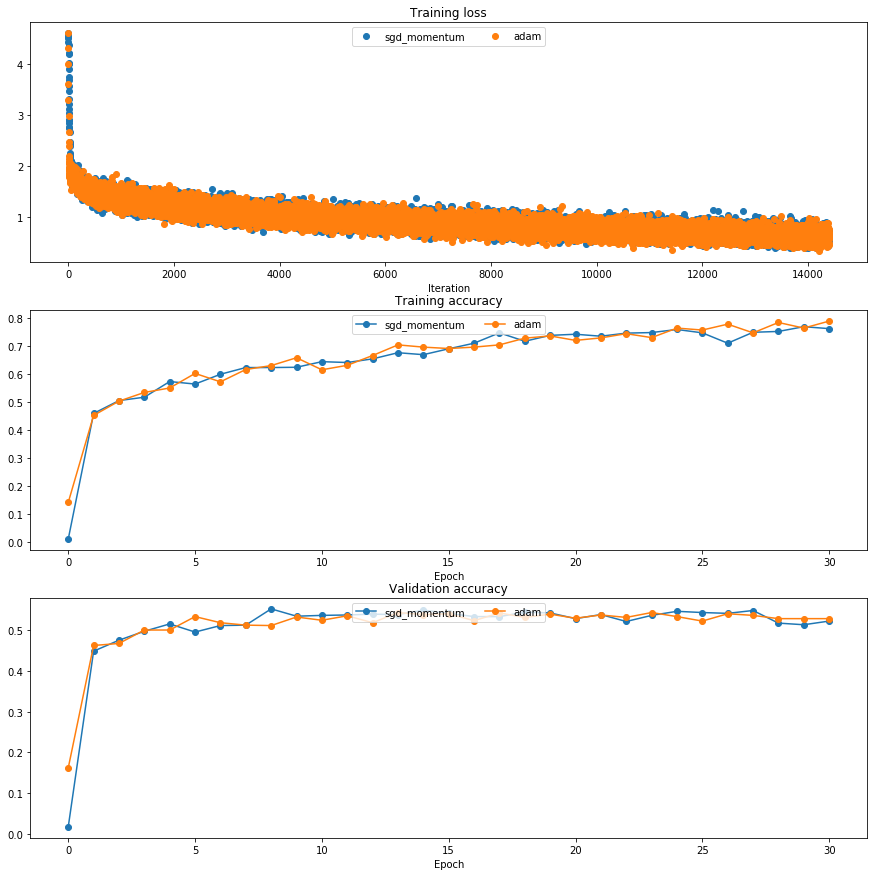

In [18]:
best_model = None
best_solver = None
best_val_acc = 0

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
# Note that dropout is not required to pass beyond the linear scoring regime   #
################################################################################
solvers = {}
learning_rates = {'adam': 1e-3, 'sgd': 1e-2,'sgd_momentum':1e-2}

#for update_rule in ['sgd', 'sgd_momentum', 'adam']:
for update_rule in ['sgd_momentum', 'adam']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=3e-2, use_batchnorm=True)

    solver = Solver(model, data,
                    num_epochs=30, batch_size=100,
                    update_rule=update_rule,
                    optim_config={'learning_rate': learning_rates[update_rule]},
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    val_acc = solver.check_accuracy(data['X_val'], data['y_val'], batch_size=100)
    print("rule = ", update_rule, " val_acc = ", val_acc)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_model = model
        best_solver = solver
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test you model
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set.

In [19]:
X_test = data['X_test']
X_val = data['X_val']
y_val = data['y_val']
y_test = data['y_test']

print("Update rule of best model = ", best_solver.update_rule)
y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())

Update rule of best model =  <function sgd_momentum at 0x7fc873096840>
Validation set accuracy:  0.556
Test set accuracy:  0.543


## Save the model

When you are satisfied with your training, save the model for submission.

In [20]:
from dl4cv.model_savers import save_fully_connected_net
save_fully_connected_net(best_model)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.5 \\
        \left(\frac{50}{\exp(0.5 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.5 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

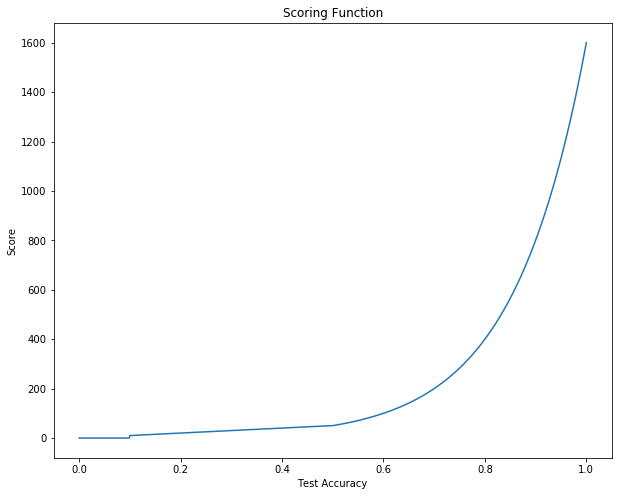

In [21]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.5, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()